In [1]:
import pickle as pkl
import numpy as np

X = pkl.load(open('./data/X_processed.pkl', 'rb'))
y = pkl.load(open('./data/y_processed.pkl', 'rb'))

print(X.shape, y.shape)

((6502, 3, 12), (6502,))


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

training_size = 6000

X_train = X[:training_size]
y_train = y[:training_size]

X_test = X[training_size:]
y_test = y[training_size:]

X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

classifier = RandomForestClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)

accuracy_score(y_test, y_pred)

0.93625498007968122

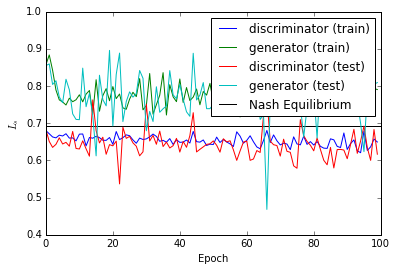

In [3]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

hist = pkl.load(open('./output/params/acgan-history.pkl', 'rb'))
losses = ['loss', 'generation_loss', 'auxiliary_loss']

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')
plt.show()



In [4]:
acgan = __import__('ac_gan')

from glob import glob
from keras.models import load_model

directory = './output/params/'

latent_size = 20

g = load_model(sorted(glob(directory + 'params_generator*'))[-1])

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
generate_count = training_size

noise = np.random.uniform(-1, 1, (generate_count, latent_size))
sampled_labels = np.random.randint(0, 2, generate_count)
generated_images = g.predict([noise, sampled_labels.reshape((-1, 1))], verbose=0)

print(generated_images.shape)
gen_X_train = np.reshape(generated_images, (training_size, 3, 12))

print(np.max(gen_X_train))

for i in range(gen_X_train.shape[0]):
    gen_X_train[i][0] = gen_X_train[i][0] * 233
    gen_X_train[i][1] = gen_X_train[i][1] * 137
    gen_X_train[i][2] = gen_X_train[i][2] * 7

gen_X_train = gen_X_train.astype(int)
print(gen_X_train[:2])
print(gen_X_train.shape)

gen_X_train = gen_X_train.reshape(generate_count, -1)
print(gen_X_train.shape)

gen_y_train = sampled_labels

unique, counts = np.unique(y_train, return_counts=True)
print('real' + str(dict(zip(unique, counts))))

unique, counts = np.unique(gen_y_train, return_counts=True)
print('gen' + str(dict(zip(unique, counts))))

print(gen_X_train.shape)
print(gen_y_train.shape)

(6000, 1, 3, 12)
0.841063
[[[172 143 117  93 118 136 151 124 134 123 146 142]
  [104  87  81  62  66  73  94  84  91  81  99  84]
  [  0   0   0   0   0   0   1   1   0   0   0   1]]

 [[171 143 117  94 119 136 151 123 135 124 147 141]
  [104  87  80  62  67  73  94  85  92  82  99  83]
  [  0   0   0   0   0   0   1   1   0   0   0   1]]]
(6000, 3, 12)
(6000, 36)
real{0: 2981, 1: 3019}
gen{0: 3036, 1: 2964}
(6000, 36)
(6000,)


In [6]:
print(gen_X_train[:5])

[[172 143 117  93 118 136 151 124 134 123 146 142 104  87  81  62  66  73
   94  84  91  81  99  84   0   0   0   0   0   0   1   1   0   0   0   1]
 [171 143 117  94 119 136 151 123 135 124 147 141 104  87  80  62  67  73
   94  85  92  82  99  83   0   0   0   0   0   0   1   1   0   0   0   1]
 [183 147 117  90 117 136 153 122 135 123 150 144 110  88  83  61  66  73
   95  85  95  83 102  85   0   0   0   0   0   0   1   0   0   0   0   0]
 [177 147 117  92 118 137 152 122 136 125 150 143 107  87  80  60  65  72
   94  85  94  84 102  85   0   0   0   0   0   0   1   0   0   0   0   0]
 [185 147 115  88 115 135 152 125 136 126 150 143 111  89  82  60  64  73
   94  87  95  86 103  85   0   0   0   0   0   0   1   0   0   0   0   0]]


In [19]:
gen_y_pred = classifier.fit(gen_X_train, gen_y_train).predict(X_test)
accuracy_score(y_test, gen_y_pred)

0.50199203187250996